
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos using Keras (CNN + LSTM)</font> </center>**

<center>
<img src='https://drive.google.com/uc?export=download&id=1ucdFpzyVbzTa7kPYsJ2av-gRKgd84ICA'></center>

## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Visualize the Data with its Labels**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Split the Data into Train and Test Set**

- **`Step 4:` Implement the ConvLSTM Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**

- **`Step 5:` implement the LRCN Approach**
 
    - **`Step 5.1:` Construct the Model**
    
    - **`Step 5.2:` Compile & Train the Model**
    
    - **`Step 5.3:` Plot Model’s Loss & Accuracy Curves**


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [11]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy
!pip install mediapipe

  Cloning https://github.com/TahaAnwar/pafy.git to c:\temp\pip-install-emk75wul\pafy_ad58bc80cd4f4070be63bc31c04ce6ed
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git 'C:\temp\pip-install-emk75wul\pafy_ad58bc80cd4f4070be63bc31c04ce6ed'


In [1]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import mediapipe as mp
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 150,150

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Front Raise Correct","Front Raise Wrong","Shoulder Press Correct","Shoulder Press Wrong"]

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [4]:

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        

    # Declare a list to store video frames.
        frames_list = []
    
    # Read the Video File using the VideoCapture object.
        video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
            success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
            if not success:
                break
            

        # Resize the Frame to fixed height and width.
            results = pose.process(frame)
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(image=frame, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
            resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
            
        # # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255
            # plt.subplot(1, 1, 1);plt.imshow(resized_frame);plt.axis('off') 
            # print(frame.shape)
        # # Append the normalized frame into the frames list
            # plt.subplot(1, 1, 1);plt.imshow(normalized_frame);plt.axis('off')
            frames_list.append(normalized_frame)
      
    
    # Release the VideoCapture object. 
        video_reader.release()

    # Return the frames list.
        return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [5]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [6]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Front Raise Correct
Extracting Data of Class: Front Raise Wrong
Extracting Data of Class: Shoulder Press Correct
Extracting Data of Class: Shoulder Press Wrong


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [7]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [8]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)


## **<font style="color:rgb(134,19,348)">Step 4: Implement the ConvLSTM Approach</font>**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015), to learn more about this architecture.


### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category. 

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [11]:
def create_pose_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [12]:
# Construct the required convlstm model.
pose_model = create_pose_model()

# Display the success message. 
print("Model Created Successfully!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 148, 148, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 74, 74, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 74, 74, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 72, 72, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 36, 36, 8)     0         
 g3D)                                                            
                                                       

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [14]:

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
pose_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
pose_model_training_history = pose_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])


Epoch 1/20


89/89 [==============================] - 79s 696ms/step - loss: 0.9389 - accuracy: 0.6620 - val_loss: 0.3834 - val_accuracy: 0.8764
Epoch 2/20
89/89 [==============================] - 61s 686ms/step - loss: 0.3010 - accuracy: 0.8761 - val_loss: 0.2245 - val_accuracy: 0.9101
Epoch 3/20
89/89 [==============================] - 66s 742ms/step - loss: 0.1704 - accuracy: 0.9408 - val_loss: 0.2244 - val_accuracy: 0.9101
Epoch 4/20
89/89 [==============================] - 65s 736ms/step - loss: 0.1249 - accuracy: 0.9521 - val_loss: 0.0682 - val_accuracy: 0.9775
Epoch 5/20
89/89 [==============================] - 64s 717ms/step - loss: 0.0672 - accuracy: 0.9775 - val_loss: 0.1487 - val_accuracy: 0.9326
Epoch 6/20
89/89 [==============================] - 64s 717ms/step - loss: 0.0530 - accuracy: 0.9746 - val_loss: 0.0335 - val_accuracy: 0.9888
Epoch 7/20
89/89 [==============================] - 68s 770ms/step - loss: 0.0316 - accuracy: 0.9859 - val_loss: 0.0371 - val_accuracy: 0.9

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [15]:
# Evaluate the trained model.
model_evaluation_history = pose_model.evaluate(features_test, labels_test)

4/4 [==============================] - 5s 1s/step - loss: 0.0225 - accuracy: 0.9910


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [16]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)


# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'pose_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
pose_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [17]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    metric_name_1='Training '+metric_name_1
    metric_name_2='Validation '+metric_name_2[4:]
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

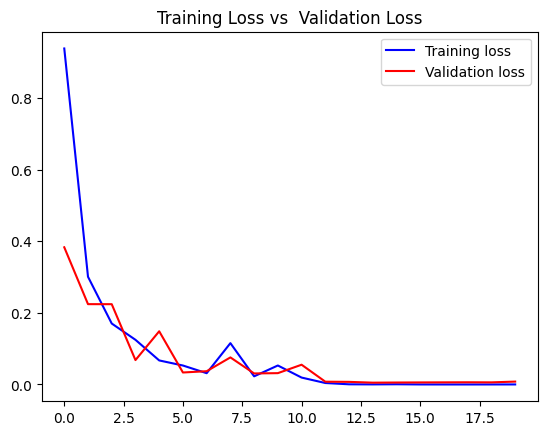

In [18]:
# Visualize the training and validation loss metrices.
plot_metric(pose_model_training_history, 'loss', 'val_loss', 'Training Loss vs  Validation Loss')

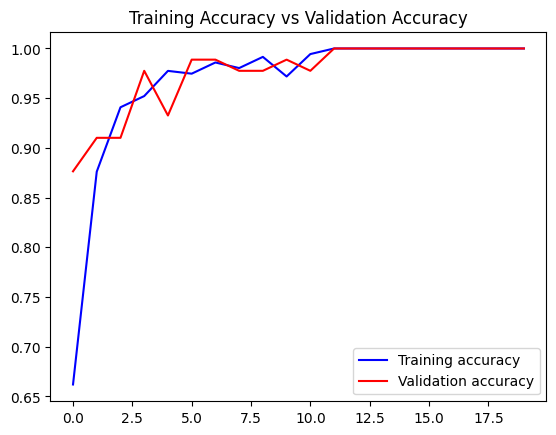

In [19]:
# Visualize the training and validation accuracy metrices.
plot_metric(pose_model_training_history, 'accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy') 

1/1 [==============================] - 0s 54ms/step


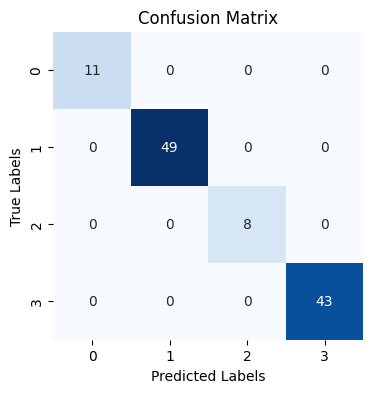

In [28]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming you have already trained your model and have it stored in 'model'
# pose_model = tf.keras.models.load_model(r'pose_model_Date_Time_2024_05_18_15_37_29_Loss_0_0037193698808550835.h5')

# Step 1: Get predictions from the model
predicted_labels=[]
for feature in features_test:
    predicted_labels_probabilities = pose_model.predict(np.expand_dims(feature, axis=0))[0]
        # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_labels.append(predicted_label)
    # print(predicted_label)

predicted_labels = np.asarray(predicted_labels)
labels=[]
for label in labels_test:
    labels.append(np.argmax(label,axis=0))
    # print(np.argmax(label,axis=0))

labels = np.asarray(labels)
conf_matrix = confusion_matrix(labels, predicted_labels)
plt.figure(figsize=(4, 4))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Ensure the plot is displayed
plt.show()

In [24]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the Pose model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
    # pose_model = tf.keras.models.load_model(r'pose_model___Date_Time_2024_05_18__15_37_29___Loss_0.0037193698808550835___Accuracy_1.0.h5')
# Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        
        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = pose_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [25]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = '1_Demo'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}_pose_model.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 55ms/step


In [26]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = 'Sec_Pro_Demo_Front_raise'

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}_pose_model.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 57ms/step
